## Elo-merchant-category-recommendation


###### The aim is develop algorithms to identify and serve the most relevant opportunities to individuals, by uncovering signal in customer loyalty

###### Packages Importing
Importing all the required packages

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
import time
from sklearn.metrics import mean_squared_error

###### Read csv
Reading the csv files in dataframes

In [7]:
hist_trans = pd.read_csv("./historical_transactions.csv",parse_dates=['purchase_date'])    #Parsing the purchase data to convert it to pandas datetime object
hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [8]:
new_merchant = pd.read_csv("./new_merchant_transactions.csv",parse_dates=['purchase_date'])
new_merchant.head(2)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19


In [5]:
merchants = pd.read_csv("./merchants.csv")
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


###### Checking for the info
1)Check the dimension of the dataframes
2)Check for the data types of the column attributes
3)Check for number of non-null values in each column

In [6]:
hist_trans.shape

(29112361, 14)

In [81]:
hist_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         int64
card_id                 object
city_id                 int64
category_1              int64
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           datetime64[ns]
category_2              float64
state_id                int64
subsector_id            int64
dtypes: datetime64[ns](1), float64(2), int64(8), object(3)
memory usage: 3.0+ GB


In [8]:
print(new_merchant.shape)
print(new_merchant.info())

(1963031, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           datetime64[ns]
category_2              float64
state_id                int64
subsector_id            int64
dtypes: datetime64[ns](1), float64(2), int64(6), object(5)
memory usage: 209.7+ MB
None


In [9]:
print(merchants.shape)
print(merchants.info())


(334696, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
merchant_id                    334696 non-null object
merchant_group_id              334696 non-null int64
merchant_category_id           334696 non-null int64
subsector_id                   334696 non-null int64
numerical_1                    334696 non-null float64
numerical_2                    334696 non-null float64
category_1                     334696 non-null object
most_recent_sales_range        334696 non-null object
most_recent_purchases_range    334696 non-null object
avg_sales_lag3                 334683 non-null float64
avg_purchases_lag3             334696 non-null float64
active_months_lag3             334696 non-null int64
avg_sales_lag6                 334683 non-null float64
avg_purchases_lag6             334696 non-null float64
active_months_lag6             334696 non-null int64
avg_sales_lag12                334683 non-null float64
avg_purcha

###### Importing the train file and checking for the info

Import the train file, check the dimension and parameters on which data can be trained

In [40]:
train = pd.read_csv("./train.csv")
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [43]:
#Converting the 3 features to categorical data
['feature_1'] = train['feature_1'].astype('category')
train['feature_2'] = train['feature_2'].astype('category')
train['feature_3'] = train['feature_3'].astype('category')

In [64]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null object
card_id               201917 non-null object
feature_1             201917 non-null category
feature_2             201917 non-null category
feature_3             201917 non-null category
target                201917 non-null float64
dtypes: category(3), float64(1), object(2)
memory usage: 5.2+ MB


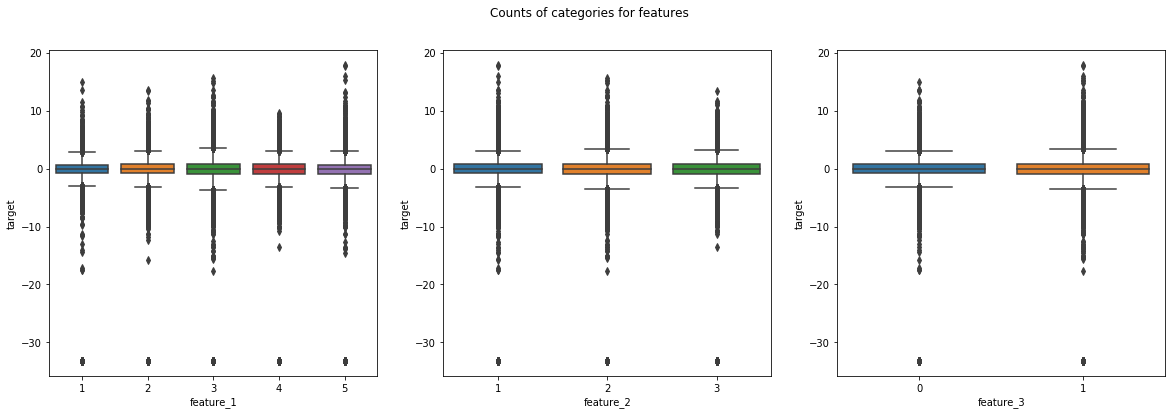

In [25]:
#Plotting the box plot for each feature in each category
fig, ax = plt.subplots(1, 3, figsize = (20, 6));
plt.suptitle('Counts of categories for features')
sns.boxplot(x="feature_1", y="target", data=train, ax=ax[0]).figure
sns.boxplot(x="feature_2", y="target", data=train, ax=ax[1]).figure
sns.boxplot(x="feature_3", y="target", data=train, ax=ax[2]).figure

###### Conclusion from parameter checking
These 3 features happens to be similar in distribution across the target value(loyalty score). So its not enough to train model for finding target based on only these parameters. We need some extra features. We can get this by merging the historical transactions data and new merchants data because these data contains extra information about each card id

###### Mapping the object data to int or float data

Authorized flag, Category_1 and category_3 are found to be the object data, so mapping them int value. As these datas are categorical in nature, few maps in a dictionory are enough. So, map_dict and map_dict1 are dictionaries to map the categorical data to int

In [9]:
map_dict = {'Y': 1, 'N': 0}
hist_trans['category_1'] = hist_trans['category_1'].apply(lambda x: map_dict[x])
hist_trans['authorized_flag'] = hist_trans['authorized_flag'].apply(lambda x: map_dict[x])
hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [10]:
map_dict1 ={'A': 0, 'B': 1, 'C': 2, np.nan: 3}
hist_trans['category_3'] = hist_trans['category_3'].apply(lambda x: map_dict1[x])
hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,1,C_ID_4e6213e9bc,88,0,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,1,C_ID_4e6213e9bc,88,0,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


###### Reducing the memory usage
As we see the transaction data and new merchant data happens to be too big (in gBs), so its necessary that we reduce the memory usage wherever possible

In [11]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

###### Aggregating the transactions details
For each card_id we group the data and find the aggregated values of all columns. 
The column fields which are int are float, we find sum, mean, max, min and std.
For categorical ḍata we find sum, mean. 
For date,time like values, we find max and min. 
For object data we find number of unique values

In [12]:
def agg_transactions(trans, pre):
    trans['purchase_month'] = trans['purchase_date'].dt.month
    trans['month_diff'] = ((dt.datetime.today() - trans['purchase_date']).dt.days)//30  #Converting diffrence to days
    trans['month_diff'] += trans['month_lag']
    trans.loc[:, 'purchase_date'] = pd.DatetimeIndex(trans['purchase_date']).astype(np.int64) * 1e-9
    trans = pd.get_dummies(trans, columns=['category_2', 'category_3'])
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['sum', 'mean'],
        'category_2_2.0': ['sum', 'mean'],
        'category_2_3.0': ['sum', 'mean'],
        'category_2_4.0': ['sum', 'mean'],
        'category_2_5.0': ['sum', 'mean'],
        'category_3_1': ['sum', 'mean'],
        'category_3_2': ['sum', 'mean'],
        'category_3_3': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': ['max', 'min'],
        'month_lag': ['min', 'max'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'subsector_id': ['nunique'],
        'city_id': ['nunique'],
    }
    #Grouping by the card_id and finding the aggregated value
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    #Renaming the aggregated column
    agg_trans.columns = [pre + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (trans.groupby('card_id').size().reset_index(name='{}transactions_count'.format(pre)))

    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')

    return agg_trans

###### Reading the train and test file and making necessary changes
Reading the train csv file and test csv file. Changing the date attribute to pandas datetime object. Extracting year, weekday and month out of date. Also calculating the elapsed time.

In [20]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    df.fillna(0)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (dt.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    date_parts = ["year", "weekday", "month"]
    for part in date_parts:
        part_col = 'first_active_month' + "_" + part
        df[part_col] = getattr(df['first_active_month'].dt, part).astype(float) 
    return df

In [21]:
train=read_data("./train.csv")

In [23]:
test=read_data("./test.csv")

In [13]:
hist_trans = reduce_mem_usage(hist_trans)

Mem. usage decreased to 1166.08 Mb (62.5% reduction)


###### Getting the history of aggreagated data

Finding the aggreagted values of all columns

In [14]:
history = agg_transactions(hist_trans, pre='hist_')

In [15]:
history.head()

,card_id,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_sum,hist_category_2_1.0_mean,hist_category_2_2.0_sum,hist_category_2_2.0_mean,...,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_min,hist_month_lag_max,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_subsector_id_nunique,hist_city_id_nunique
0,C_ID_00007093c1,149,114.0,0.765101,28.0,0.187919,0.0,0.000000,0.0,0.000000,...,1,3.303308,1.519708e+09,1.487081e+09,-12,0,18,3,13,4
1,C_ID_0001238066,123,120.0,0.975610,2.0,0.016260,95.0,0.772358,0.0,0.000000,...,1,4.895850,1.519748e+09,1.506638e+09,-5,0,29,6,17,18
2,C_ID_0001506ef0,66,62.0,0.939394,0.0,0.000000,2.0,0.030303,0.0,0.000000,...,1,4.524190,1.518871e+09,1.484411e+09,-13,0,19,2,12,3
3,C_ID_0001793786,216,189.0,0.875000,2.0,0.009259,11.0,0.050926,76.0,0.351852,...,1,2.306373,1.509481e+09,1.484994e+09,-9,0,48,4,24,10
4,C_ID_000183fdda,144,137.0,0.951389,4.0,0.027778,7.0,0.048611,1.0,0.006944,...,1,4.439959,1.519592e+09,1.502099e+09,-6,0,36,7,21,9


###### Merging the data
Merging the train data and historical transactions aggregated data on card_id

In [24]:
train = pd.merge(train, history, on='card_id', how='left')

In [25]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,elapsed_time,first_active_month_year,first_active_month_weekday,first_active_month_month,...,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_min,hist_month_lag_max,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_subsector_id_nunique,hist_city_id_nunique
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,245,2017.0,3.0,6.0,...,1,3.474193,1.519551e+09,1.498573e+09,-8,0,41,3,21,7
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,396,2017.0,6.0,1.0,...,1,3.848142,1.517438e+09,1.483720e+09,-12,0,57,3,24,9
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,549,2016.0,0.0,8.0,...,1,3.275467,1.519759e+09,1.484123e+09,-13,0,8,2,7,5
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,153,2017.0,4.0,9.0,...,1,3.904797,1.519818e+09,1.506443e+09,-5,0,25,5,13,7
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,92,2017.0,2.0,11.0,...,1,5.003086,1.519850e+09,1.510445e+09,-3,0,26,6,17,6


###### Merging the data
Merging the test data and historical transactions aggregated data on card_id

In [26]:
test = pd.merge(test, history, on='card_id', how='left')

In [27]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,first_active_month_year,first_active_month_weekday,first_active_month_month,hist_transactions_count,...,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_min,hist_month_lag_max,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_subsector_id_nunique,hist_city_id_nunique
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,306.0,2017.0,5.0,4.0,68,...,4,2.454994,1.514510e+09,1.491330e+09,-8,0,16,3,12,7
1,2017-01-01,C_ID_130fd0cbdd,2,3,0,396.0,2017.0,6.0,1.0,78,...,1,1.357016,1.518989e+09,1.484321e+09,-13,0,16,3,12,4
2,2017-08-01,C_ID_b709037bc5,5,1,1,184.0,2017.0,1.0,8.0,13,...,1,4.819831,1.517598e+09,1.503673e+09,-6,0,8,4,6,4
3,2017-12-01,C_ID_d27d835a9f,2,1,0,62.0,2017.0,4.0,12.0,26,...,1,5.136296,1.519127e+09,1.512392e+09,-2,0,18,1,11,1
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1,793.0,2015.0,1.0,12.0,110,...,1,3.361572,1.519728e+09,1.483444e+09,-13,0,31,4,15,5


###### Mapping the new_transaction data

Similar to historical transaction data mapping new transactions data

In [28]:
map_dict = {'Y': 1, 'N': 0}
new_merchant['category_1'] = new_merchant['category_1'].apply(lambda x: map_dict[x])
new_merchant['authorized_flag'] = new_merchant['authorized_flag'].apply(lambda x: map_dict[x])
new_merchant.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_415bb3a509,107,0,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,1,C_ID_415bb3a509,140,0,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,1,C_ID_415bb3a509,330,0,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,1,C_ID_415bb3a509,-1,1,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,1,C_ID_ef55cf8d4b,-1,1,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [29]:
map_dict1 ={'A': 0, 'B': 1, 'C': 2, np.nan: 3}
new_merchant['category_3'] = new_merchant['category_3'].apply(lambda x: map_dict1[x])
new_merchant.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_415bb3a509,107,0,1,1,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,1,C_ID_415bb3a509,140,0,1,1,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,1,C_ID_415bb3a509,330,0,1,1,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,1,C_ID_415bb3a509,-1,1,1,1,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,1,C_ID_ef55cf8d4b,-1,1,1,1,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [30]:
new_merchant = reduce_mem_usage(new_merchant)

Mem. usage decreased to 74.88 Mb (64.3% reduction)


###### Getting the aggregated values for new_transactions

Finding the aggreagted values of all columns

In [31]:
new_data = agg_transactions(new_merchant, pre='new_')

###### Merging the train data and new_data

Merging the train data and new_data on card_id. Now as our train data already has info of historical transactions, merging it with new transactional data, yields us the complete merged data.

In [32]:
train = pd.merge(train, new_data, on='card_id', how='left')

In [33]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,elapsed_time,first_active_month_year,first_active_month_weekday,first_active_month_month,...,new_purchase_month_min,new_purchase_month_std,new_purchase_date_max,new_purchase_date_min,new_month_lag_min,new_month_lag_max,new_merchant_category_id_nunique,new_state_id_nunique,new_subsector_id_nunique,new_city_id_nunique
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,245,2017.0,3.0,6.0,...,3.0,0.510754,1.525001e+09,1.520259e+09,1.0,2.0,14.0,1.0,10.0,3.0
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,396,2017.0,6.0,1.0,...,2.0,0.547723,1.522393e+09,1.517505e+09,1.0,2.0,5.0,1.0,4.0,1.0
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,549,2016.0,0.0,8.0,...,4.0,NaN,1.524937e+09,1.524937e+09,2.0,2.0,1.0,1.0,1.0,1.0
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,153,2017.0,4.0,9.0,...,3.0,0.487950,1.524049e+09,1.520424e+09,1.0,2.0,6.0,2.0,5.0,2.0
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,92,2017.0,2.0,11.0,...,3.0,0.503953,1.524941e+09,1.519992e+09,1.0,2.0,17.0,5.0,10.0,5.0


In [34]:
test = pd.merge(test, history, on='card_id', how='left')

In [35]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,first_active_month_year,first_active_month_weekday,first_active_month_month,hist_transactions_count,...,new_purchase_month_min,new_purchase_month_std,new_purchase_date_max,new_purchase_date_min,new_month_lag_min,new_month_lag_max,new_merchant_category_id_nunique,new_state_id_nunique,new_subsector_id_nunique,new_city_id_nunique
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,306.0,2017.0,5.0,4.0,68,...,2.0,0.000000,1.519845e+09,1.517651e+09,2.0,2.0,3.0,1.0,3.0,3.0
1,2017-01-01,C_ID_130fd0cbdd,2,3,0,396.0,2017.0,6.0,1.0,78,...,3.0,0.527046,1.524247e+09,1.520080e+09,1.0,2.0,8.0,2.0,6.0,2.0
2,2017-08-01,C_ID_b709037bc5,5,1,1,184.0,2017.0,1.0,8.0,13,...,3.0,0.000000,1.520947e+09,1.519916e+09,1.0,1.0,2.0,2.0,2.0,2.0
3,2017-12-01,C_ID_d27d835a9f,2,1,0,62.0,2017.0,4.0,12.0,26,...,3.0,0.483046,1.524000e+09,1.520162e+09,1.0,2.0,10.0,3.0,8.0,3.0
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1,793.0,2015.0,1.0,12.0,110,...,3.0,0.408248,1.523535e+09,1.520132e+09,1.0,2.0,5.0,2.0,4.0,2.0


###### Saving the data to csv file

Saving the clean train and test data to the proper csv file.

In [36]:
#In train file we have target value (the loyalty score).Adding it as last column 
target=train['target']
del train['target']
train['target'] = target
train.to_csv('train_final.csv')

In [37]:
test.to_csv('test_final.csv')

###### Reading the data and training the model

Now, reading the clean train and test data, so that we can train the model on it.

In [38]:
train_final = pd.read_csv("./train_final.csv")

In [39]:
test_final = pd.read_csv("./test_final.csv")

###### Checking for the info
 Check the info, i.e., data type and non null values to ensure that we have all int and float values and no null values in any column

In [56]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 96 columns):
Unnamed: 0                           201917 non-null int64
feature_1                            201917 non-null int64
feature_2                            201917 non-null int64
feature_3                            201917 non-null int64
elapsed_time                         201917 non-null int64
first_active_month_year              201917 non-null float64
first_active_month_weekday           201917 non-null float64
first_active_month_month             201917 non-null float64
hist_transactions_count              201917 non-null int64
hist_authorized_flag_sum             201917 non-null float64
hist_authorized_flag_mean            201917 non-null float64
hist_category_1_sum                  201917 non-null float64
hist_category_1_mean                 201917 non-null float64
hist_category_2_1.0_sum              201917 non-null float64
hist_category_2_1.0_mean             201917 non

In [57]:
test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Data columns (total 96 columns):
Unnamed: 0                           123623 non-null int64
feature_1                            123623 non-null int64
feature_2                            123623 non-null int64
feature_3                            123623 non-null int64
elapsed_time                         123623 non-null float64
first_active_month_year              123623 non-null float64
first_active_month_weekday           123623 non-null float64
first_active_month_month             123623 non-null float64
hist_transactions_count              123623 non-null int64
hist_authorized_flag_sum             123623 non-null float64
hist_authorized_flag_mean            123623 non-null float64
hist_category_1_sum                  123623 non-null float64
hist_category_1_mean                 123623 non-null float64
hist_category_2_1.0_sum              123623 non-null float64
hist_category_2_1.0_mean             123623 n

###### Filling up the null values

For any columns where there is null value, we fill it with zero(0)

In [41]:
for col in train_final.columns:
    if train_final[col].isnull().any():
        train_final[col] = train_final[col].fillna(0)

In [44]:
for col in test_final.columns:
    if test_final[col].isnull().any():
        test_final[col] = test_final[col].fillna(0)

###### Extracting the target value and dropping the unnecessary columns

Save the target value or value to be predicted. Now our train data should only contain the value on which we have to train the model. Hence dropping the unnecessary columns from train and test data.


In [51]:
y=train_final['target']

In [52]:
drop_col_train= ['first_active_month', 'card_id', 'target']
drop_col_test= ['first_active_month', 'card_id']

In [ ]:
train_final.drop(drop_col_train, axis=1, inplace=True)
test_final.drop(drop_col_test, axis=1, inplace=True)

### Training the model

In [58]:
X = train_final
X_test = test_final

###### Creating the folds for cross validation
K-Folds cross-validator
Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).
Each fold is then used once as a validation while the k - 1 remaining folds form the training set

In [75]:
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

###### Declaring the parameters

Declaring the parameters LightGBM regression model. Light GBM is a gradient boosting framework that uses tree based learning algorithm.

In [87]:
params = {'max_depth': 15,
         'num_leaves': 65,
         'min_data_in_leaf':80, 
         'objective':'regression',
         'learning_rate': 0.002,
         "boosting": "gbdt",
         "feature_fraction": 0.75,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

###### Training the model 
Training the model. Cross validating the train data based on folds we created. Finding the root mean squared error as metric to check the training model.Finally predicting the value for test data. Also finding the feature importance of each parameter for each fold.

In [88]:
def train_model(X=X, X_test=X_test, y=y, params=None, folds=folds, plot_feature_importance=False):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        #Data for training and validation
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
        model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=200)
        y_pred_valid = model.predict(X_valid)
        y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        prediction += y_pred  
        #Feature Importances for all the features used in training data
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = X.columns
        fold_importance["importance"] = model.feature_importances_
        fold_importance["fold"] = fold_n + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    prediction /= n_fold
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    feature_importance["importance"] /= n_fold
    if plot_feature_importance:
        cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

        best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

        plt.figure(figsize=(16, 12));
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
        plt.title('LGB Features (avg over folds)');
        
        return oof, prediction, feature_importance
    return oof, prediction

In [92]:
oof_lgb, prediction_lgb, feature_importance = train_model(params=params, plot_feature_importance=True)

Fold 0 started at Mon Dec 24 14:48:54 2018
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 3.58466	valid_1's rmse: 3.78085
[2000]	training's rmse: 3.50166	valid_1's rmse: 3.75969
[3000]	training's rmse: 3.44422	valid_1's rmse: 3.75504
[4000]	training's rmse: 3.3955	valid_1's rmse: 3.75396
Early stopping, best iteration is:
[4166]	training's rmse: 3.38787	valid_1's rmse: 3.75371
Fold 1 started at Mon Dec 24 14:59:20 2018
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 3.59301	valid_1's rmse: 3.69761
[2000]	training's rmse: 3.50943	valid_1's rmse: 3.67786
[3000]	training's rmse: 3.45127	valid_1's rmse: 3.67249
[4000]	training's rmse: 3.40253	valid_1's rmse: 3.67009
Early stopping, best iteration is:
[4497]	training's rmse: 3.38005	valid_1's rmse: 3.66926
Fold 2 started at Mon Dec 24 15:09:29 2018
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 3.60375	valid_1's rmse: 3.589

In [93]:
feature_importance

,feature,importance,fold
0,Unnamed: 0,651.7,1
1,feature_1,174.2,1
2,feature_2,110.8,1
3,feature_3,60.5,1
4,elapsed_time,596.4,1
5,first_active_month_year,43.8,1
6,first_active_month_weekday,179.2,1
7,first_active_month_month,266.8,1
8,hist_transactions_count,407.1,1
9,hist_authorized_flag_sum,404.3,1


###### Storing the predicted value
Storing the predicted value in sample_submission.csv file, the file to be submitted.

In [95]:
submission_data = pd.read_csv("./sample_submission.csv")

In [96]:
submission_data['target']=prediction_lgb

In [98]:
submission_data.to_csv('sample_submission.csv')